# Emergent Constraints with Spatial Dependence and Copula Approaches

This notebook implements the framework described in the documentation:
- Emergent constraints for future warming trends using historical spatial patterns.
- Introduction of equi-sparsity for high-dimensional regression.
- Extension to non-Gaussian frameworks using copulas.

In [45]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV
import scipy.spatial as spatial
import scipy.optimize as opt
import geopandas as gpd
from copulas.multivariate import GaussianMultivariate, VineCopula

# Set plotting defaults
sns.set_theme(style="whitegrid")

In [46]:
data_path = "data.nc"
ds = xr.open_dataset(data_path)

# Extract variables
X_esm = ds["GSAT_hist_trd_model"].values  # shape (lon, lat, sample_id)
Y_obs = ds["GSAT_hist_trd_obs"].values    # shape (lon, lat)
Z_future_near = ds["GSAT_delta_model_near"].values  # shape (sample_id,)
Z_future_mid = ds["GSAT_delta_model_mid"].values    # shape (sample_id,)
Z_future_long = ds["GSAT_delta_model_long"].values  # shape (sample_id,)

lons = ds["lon"].values
lats = ds["lat"].values
sample_ids = ds["sample_id"].values

ds.close()

# Dimensions: lon: L, lat: M, sample_id: N
L = len(lons)
M = len(lats)
N = len(sample_ids)

# We’ll focus on near-term future projection (Z_future_near) for demonstration
Z = Z_future_near

In [47]:
# Earth's radius in km
R = 6371.0

# Convert lat/lon to radians
lats_rad = np.radians(lats)
lons_rad = np.radians(lons)

# Compute area weights
# Each cell: area ~ (sin(lat+delta)-sin(lat))*(delta_lon)*R^2
# delta in radians for 5° = 5*(pi/180)
delta_lat = np.abs(lats_rad[1] - lats_rad[0])
delta_lon = np.abs(lons_rad[1] - lons_rad[0])

# Create a meshgrid for lat/lon
Lon2d, Lat2d = np.meshgrid(lons_rad, lats_rad, indexing='xy')

# Area of each cell
area = ( (np.sin(Lat2d+delta_lat/2) - np.sin(Lat2d - delta_lat/2)) 
         * delta_lon * R**2 )

area = np.abs(area)  # ensure positive

# Flatten the grid
X_esm_flat = X_esm.reshape(L*M, N).T  # shape: N x (L*M)
Y_obs_flat = Y_obs.reshape(L*M)
area_flat = area.reshape(L*M)

# Compute pairwise distances between grid cell centers
coords = np.column_stack([Lon2d.ravel(), Lat2d.ravel()])
# Convert lat/lon to cartesian for distance:
def latlon_to_xyz(lon_rad, lat_rad):
    x = np.cos(lat_rad) * np.cos(lon_rad)
    y = np.cos(lat_rad) * np.sin(lon_rad)
    z = np.sin(lat_rad)
    return x, y, z

xyz = np.array([latlon_to_xyz(lon, lat) for lon, lat in coords])
dist_matrix = spatial.distance.cdist(xyz, xyz, metric='euclidean')
# dist_matrix now approx. chordal distances on unit sphere, 
# optionally convert to actual surface distance: dist_in_km = dist_matrix * R
dist_matrix = dist_matrix * R

In [48]:
X = X_esm_flat
Y = Y_obs_flat

print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("Z shape:", Z.shape)

X shape: (248, 2592)
Y shape: (2592,)
Z shape: (248,)


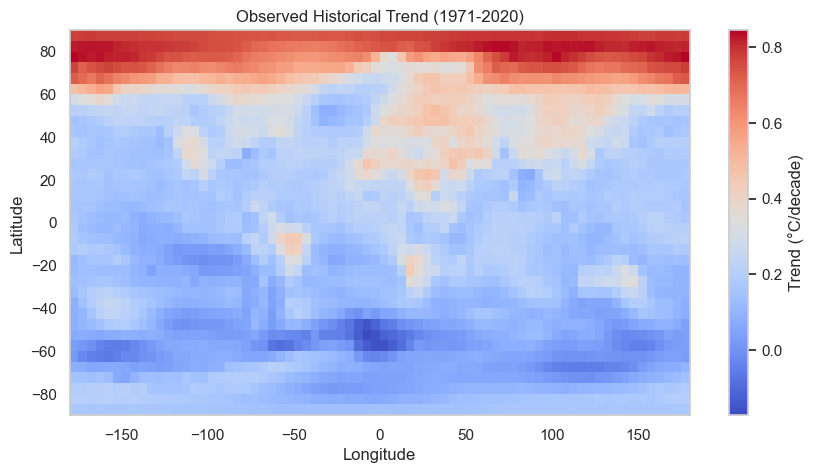

In [49]:
# Plot observed historical trend map
plt.figure(figsize=(10,5))
plt.title("Observed Historical Trend (1971-2020)")
plt.pcolormesh(lons, lats, Y_obs, cmap='coolwarm')
plt.colorbar(label='Trend (°C/decade)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

(248, 2592)
(72, 36)


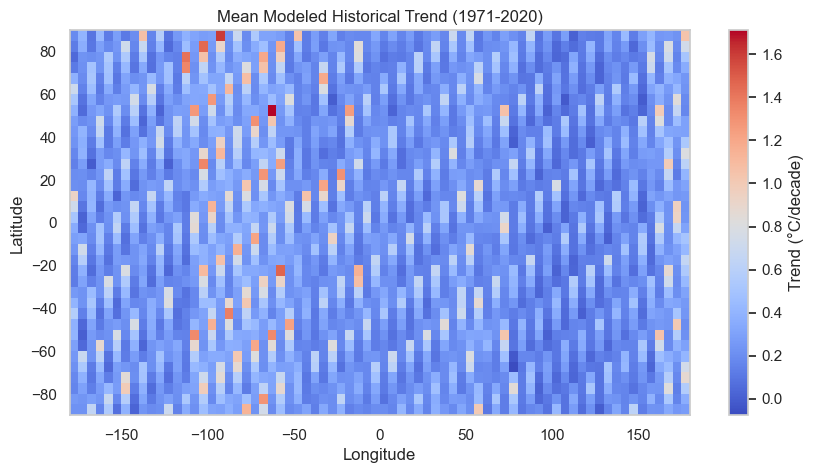

In [ ]:
# Compute ensemble mean historical trend from ESM
X_mean = X.mean(axis=0).reshape(L, M)
plt.figure(figsize=(10,5))
plt.title("Mean Modeled Historical Trend (1971-2020)")
plt.pcolormesh(lons, lats, X_mean.T, cmap='coolwarm')
plt.colorbar(label='Trend (°C/decade)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# Flatten the data to 1D for sorting
flat_data = X_mean.ravel()

# Get the indices that would sort the array
sorted_indices = np.argsort(flat_data)

# Lowest 10 values
lowest_10_indices = sorted_indices[:10]
# Highest 10 values
highest_10_indices = sorted_indices[-10:]

print("Lowest 10 values:")
for idx in lowest_10_indices:
    # Convert flat index to 2D (lon, lat)
    lon_idx, lat_idx = np.unravel_index(idx, X_mean.shape)
    val = X_mean[lon_idx, lat_idx]
    lon_val = lons[lon_idx]
    lat_val = lats[lat_idx]
    print(f"Value: {val:.4f}, Position: (lon_idx={lon_idx}, lat_idx={lat_idx}), Coordinates: (lon={lon_val:.2f}, lat={lat_val:.2f})")

print("\nHighest 10 values:")
for idx in highest_10_indices:
    # Convert flat index to 2D (lon, lat)
    lon_idx, lat_idx = np.unravel_index(idx, X_mean.shape)
    val = X_mean[lon_idx, lat_idx]
    lon_val = lons[lon_idx]
    lat_val = lats[lat_idx]
    print(f"Value: {val:.4f}, Position: (lon_idx={lon_idx}, lat_idx={lat_idx}), Coordinates: (lon={lon_val:.2f}, lat={lat_val:.2f})")

Lowest 10 values:
Value: -0.0772, Position: (lon_idx=51, lat_idx=4), Coordinates: (lon=77.50, lat=-67.50)
Value: -0.0240, Position: (lon_idx=51, lat_idx=5), Coordinates: (lon=77.50, lat=-62.50)
Value: -0.0143, Position: (lon_idx=57, lat_idx=29), Coordinates: (lon=107.50, lat=57.50)
Value: -0.0109, Position: (lon_idx=66, lat_idx=29), Coordinates: (lon=152.50, lat=57.50)
Value: -0.0108, Position: (lon_idx=2, lat_idx=23), Coordinates: (lon=-167.50, lat=27.50)
Value: -0.0036, Position: (lon_idx=51, lat_idx=25), Coordinates: (lon=77.50, lat=37.50)
Value: -0.0028, Position: (lon_idx=61, lat_idx=0), Coordinates: (lon=127.50, lat=-87.50)
Value: -0.0008, Position: (lon_idx=30, lat_idx=29), Coordinates: (lon=-27.50, lat=57.50)
Value: 0.0039, Position: (lon_idx=1, lat_idx=7), Coordinates: (lon=-172.50, lat=-52.50)
Value: 0.0042, Position: (lon_idx=55, lat_idx=17), Coordinates: (lon=97.50, lat=-2.50)

Highest 10 values:
Value: 1.3294, Position: (lon_idx=14, lat_idx=7), Coordinates: (lon=-107.50, l

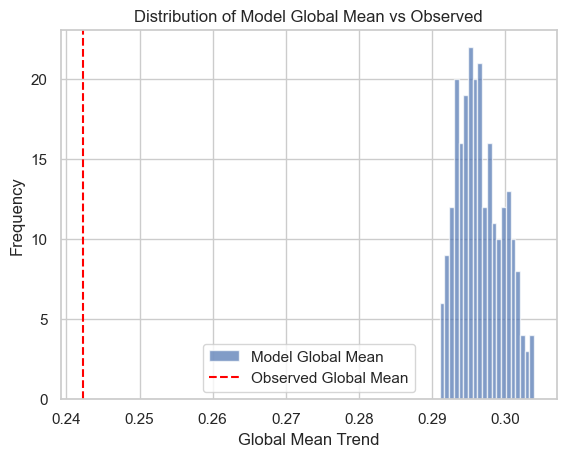

In [7]:
X_global_mean = X.mean(axis=1)
Y_global_mean = Y.mean()

plt.figure()
plt.hist(X_global_mean, bins=20, alpha=0.7, label='Model Global Mean')
plt.axvline(Y_global_mean, color='red', linestyle='--', label='Observed Global Mean')
plt.title("Distribution of Model Global Mean vs Observed")
plt.xlabel("Global Mean Trend")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_global_mean.reshape(-1,1), Z)
print("Intercept:", lr.intercept_, "Coefficient:", lr.coef_[0])

Z_pred = lr.predict(X_global_mean.reshape(-1,1))

Intercept: -1.765124731919278 Coefficient: 11.622492769658935


**Interpretation:**  
We have a simple emergent constraint model that uses the global mean historical trend to predict the future warming. Next, we will refine this approach by considering spatial patterns and an equi-sparsity penalty.

In [9]:
Sigma_X = np.cov(X, rowvar=False)  # p x p covariance matrix of historical trends across ESMs
print("Sigma_X shape:", Sigma_X.shape)

Sigma_X shape: (2592, 2592)


In [10]:
# Baseline: Ridge
alphas = np.logspace(-3, 3, 10)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X, Z)
print("Chosen alpha (Ridge):", ridge_cv.alpha_)
print("R2 score:", ridge_cv.score(X, Z))

Chosen alpha (Ridge): 1000.0
R2 score: 0.4651561332976384


In [23]:
# Section 1: Imports and Weight Computations

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from scipy.spatial import distance_matrix
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import multiprocessing

# Assuming you have already defined the following variables:
# X: shape (N, p) - Design matrix
# Z: shape (N,) - Response variable
# area_flat: shape (p,) - Area weights for each grid box
# dist_matrix: shape (p, p) - Distance matrix between grid boxes
# lons: array of longitude values
# lats: array of latitude values
# L: number of longitude grid points
# M: number of latitude grid points

# Define parameters for cross-validation
K = 5  # Number of cross-validation folds
lambda_values = np.logspace(-3, 2, 10)  # Lambda values from 0.001 to 100
epsilon = 1e-3  # Small constant to avoid division by zero

p = X.shape[1]  # Number of grid boxes (e.g., 72 * 36 = 2592)
N = X.shape[0]  # Number of samples (e.g., 248)

# Step 1: Compute weights based on distance matrix with cutoff to create sparsity
print("Computing weights based on distance matrix...")

# Precompute upper triangle indices (excluding diagonal)
j_indices, k_indices = np.triu_indices(p, k=1)

# Define a cutoff distance to retain top 10% closest pairs
cutoff_percentile = 25  # Retain top 10% closest pairs
cutoff_distance = np.percentile(dist_matrix[j_indices, k_indices], cutoff_percentile)
print(f"Applying cutoff distance at the {cutoff_percentile}th percentile: {cutoff_distance:.2f}")

# Create mask for distances below the cutoff
mask = dist_matrix[j_indices, k_indices] < cutoff_distance

# Number of unique pairs retained
num_unique_pairs = np.sum(mask)
print(f"Number of unique (j,k) pairs retained: {num_unique_pairs} out of {len(j_indices)} (~{(num_unique_pairs / len(j_indices)) * 100:.2f}%)")

# Create arrays for the retained pairs
j_retained = j_indices[mask]
k_retained = k_indices[mask]
s_j_retained = area_flat[j_retained]
s_k_retained = area_flat[k_retained]
W_retained = 1.0 / (dist_matrix[j_retained, k_retained] + epsilon)

# Convert to sparse matrix format
# Initialize an empty sparse matrix
W_sparse = csr_matrix((W_retained, (j_retained, k_retained)), shape=(p, p))
# Since W is symmetric, add its transpose
W_sparse = W_sparse + W_sparse.T

print(f"Weights matrix shape: {W_sparse.shape}")
print(f"Number of non-zero weights: {W_sparse.nnz} (density: {W_sparse.nnz / (p*p):.6f})")

print("Weights computation completed.")

Computing weights based on distance matrix...
Applying cutoff distance at the 25th percentile: 6027.62
Number of unique (j,k) pairs retained: 839472 out of 3357936 (~25.00%)
Weights matrix shape: (2592, 2592)
Number of non-zero weights: 1678944 (density: 0.249900)
Weights computation completed.


In [24]:
# Section 2: Training Loop (Cross-Validation)

from functools import partial

# Extract area weights s_j for each grid box
s = area_flat

# Initialize cross-validation results dictionary
cv_mse = {lambda_val: [] for lambda_val in lambda_values}

# Set up K-Fold cross-validation
kf = KFold(n_splits=K, shuffle=True, random_state=42)

print("\nStarting cross-validation to select the best lambda...")

# Convert W_sparse to COO format for efficient row/col/data extraction
W_sparse_coo = W_sparse.tocoo()
j_all = W_sparse_coo.row
k_all = W_sparse_coo.col
W_all = W_sparse_coo.data

# To avoid duplicating penalty terms (since W is symmetric), only process upper triangle
# Filter to keep j < k
upper_mask = j_all < k_all
j_upper = j_all[upper_mask]
k_upper = k_all[upper_mask]
W_upper = W_all[upper_mask]
s_j_upper = s[j_upper]
s_k_upper = s[k_upper]

# Define a function to perform a single fold's optimization
def perform_fold(lambda_val, train_index, val_index, X, Z, j_upper, k_upper, s_j_upper, s_k_upper, W_upper):
    X_train, X_val = X[train_index], X[val_index]
    Z_train, Z_val = Z[train_index], Z[val_index]
    
    # Define the optimization variable
    beta = cp.Variable(p)
    
    # Define the loss term (1/(2N)) * ||Z_train - X_train * beta||²
    residual = Z_train - X_train @ beta
    loss = 0.5 * (1.0 / len(Z_train)) * cp.sum_squares(residual)
    
    # Vectorized equi-sparsity penalty computation
    beta_j = cp.multiply(beta[j_upper], s_j_upper)
    beta_k = cp.multiply(beta[k_upper], s_k_upper)
    diff = beta_j - beta_k
    penalty = cp.sum(cp.multiply(W_upper, cp.abs(diff)))
    
    # Define the objective
    objective = loss + lambda_val * penalty
    problem = cp.Problem(cp.Minimize(objective))
    
    # Solve the problem
    try:
        problem.solve(solver=cp.OSQP, verbose=False)
        if problem.status in ["optimal", "optimal_inaccurate"]:
            beta_hat = beta.value
            # Predict on validation set
            Z_val_pred = X_val @ beta_hat
            mse = np.mean((Z_val - Z_val_pred) ** 2)
            return mse
        else:
            print(f"    Warning: Solver status {problem.status} for lambda {lambda_val} on a fold")
            return np.inf
    except Exception as e:
        print(f"    Error solving for lambda {lambda_val} on a fold: {e}")
        return np.inf

# Prepare parameters for parallel processing
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available for parallel processing: {num_cores}")

# To prevent memory overload, set n_jobs to min(num_cores, len(lambda_values), 4)
# Adjust '4' based on your system's RAM; lower if necessary
n_jobs = min(num_cores, len(lambda_values), 4)  # Number of parallel jobs

# Loop over lambda values and perform cross-validation in parallel
for lambda_val in lambda_values:
    print(f"\nEvaluating lambda = {lambda_val}")
    
    # Create a list of (train_index, val_index) tuples for the current lambda
    folds = list(kf.split(X))
    
    # Use joblib's Parallel and delayed to parallelize the folds
    # Each fold is independent, so they can be processed in parallel
    mse_list = Parallel(n_jobs=n_jobs)(
        delayed(perform_fold)(
            lambda_val,
            train_index,
            val_index,
            X,
            Z,
            j_upper,
            k_upper,
            s_j_upper,
            s_k_upper,
            W_upper
        )
        for train_index, val_index in folds
    )
    
    # Append the MSEs to the cv_mse dictionary
    cv_mse[lambda_val].extend(mse_list)
    print(f"  Completed lambda = {lambda_val}")
    
print("\nCross-validation completed.")


Starting cross-validation to select the best lambda...
Number of CPU cores available for parallel processing: 12

Evaluating lambda = 0.001
  Completed lambda = 0.001

Evaluating lambda = 0.003593813663804626
  Completed lambda = 0.003593813663804626

Evaluating lambda = 0.01291549665014884
  Completed lambda = 0.01291549665014884

Evaluating lambda = 0.046415888336127795
  Completed lambda = 0.046415888336127795

Evaluating lambda = 0.1668100537200059
  Completed lambda = 0.1668100537200059

Evaluating lambda = 0.5994842503189409
  Completed lambda = 0.5994842503189409

Evaluating lambda = 2.1544346900318843
  Completed lambda = 2.1544346900318843

Evaluating lambda = 7.742636826811277
  Completed lambda = 7.742636826811277

Evaluating lambda = 27.825594022071257
  Completed lambda = 27.825594022071257

Evaluating lambda = 100.0
  Completed lambda = 100.0

Cross-validation completed.



Best lambda selected from cross-validation: 0.046415888336127795
Corresponding average CV MSE: 0.17591836144849313


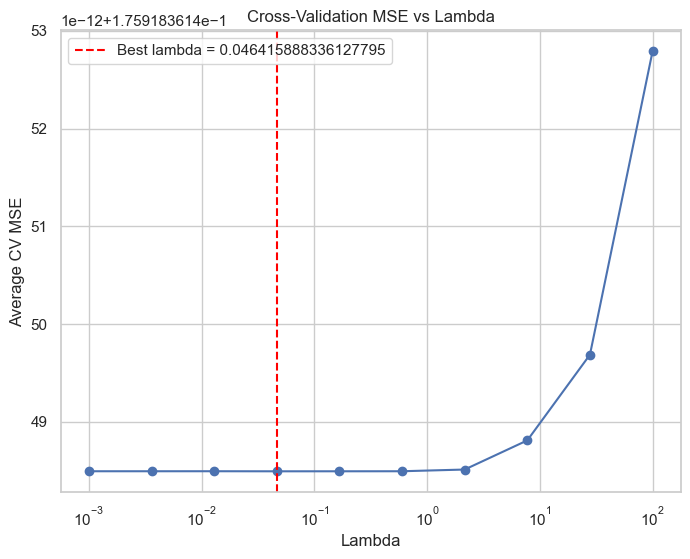

In [25]:
# Section 3: Selecting the Best Lambda

# Step 2: Select the best lambda with the lowest average MSE
avg_cv_mse = {lambda_val: np.mean(mse_list) for lambda_val, mse_list in cv_mse.items()}
best_lambda = min(avg_cv_mse, key=avg_cv_mse.get)
print(f"\nBest lambda selected from cross-validation: {best_lambda}")
print(f"Corresponding average CV MSE: {avg_cv_mse[best_lambda]}")

# Optional: Plot CV MSE vs Lambda
plt.figure(figsize=(8,6))
plt.semilogx(lambda_values, [avg_cv_mse[l] for l in lambda_values], marker='o')
plt.axvline(best_lambda, color='red', linestyle='--', label=f'Best lambda = {best_lambda}')
plt.title("Cross-Validation MSE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Average CV MSE")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Section 4: Fitting the Final Model

print("\nFitting the final model with the best lambda on the full dataset...")

# Define the optimization variable
beta_final = cp.Variable(p)

# Vectorized equi-sparsity penalty computation
beta_j_final = cp.multiply(beta_final[j_upper], s_j_upper)
beta_k_final = cp.multiply(beta_final[k_upper], s_k_upper)
diff_final = beta_j_final - beta_k_final
penalty_final = cp.sum(cp.multiply(W_upper, cp.abs(diff_final)))

# Define the loss term (1/(2N)) * ||Z - X * beta||²
residual_final = Z - X @ beta_final
loss_final = 0.5 * (1.0 / N) * cp.sum_squares(residual_final)

# Define the objective
objective_final = loss_final + best_lambda * penalty_final
problem_final = cp.Problem(cp.Minimize(objective_final))

# Solve the problem
print(f"Solving the equi-sparsity optimization problem with lambda = {best_lambda}...")
problem_final.solve(verbose=True, solver=cp.OSQP)

if problem_final.status in ["optimal", "optimal_inaccurate"]:
    beta_hat = beta_final.value
    print("Equi-sparsity coefficients solved successfully.")
else:
    print("Solver did not find an optimal solution. Status:", problem_final.status)


Fitting the final model with the best lambda on the full dataset...
Solving the equi-sparsity optimization problem with lambda = 0.046415888336127795...
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Dec 09 01:42:54 PM: Your problem has 2592 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 09 01:42:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 09 01:42:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 09 01:42:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 09 01:42:54 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                               


Reshaping and visualizing the spatial coefficients...
[[0.01478963 0.01478963 0.01478963 ... 0.01478963 0.01478963 0.01478963]
 [0.00494242 0.00494242 0.00494242 ... 0.00494242 0.00494242 0.00494242]
 [0.00298058 0.00298058 0.00298058 ... 0.00298058 0.00298058 0.00298058]
 ...
 [0.00298058 0.00298058 0.00298058 ... 0.00298058 0.00298058 0.00298058]
 [0.00494242 0.00494242 0.00494242 ... 0.00494242 0.00494242 0.00494242]
 [0.01478963 0.01478963 0.01478963 ... 0.01478963 0.01478963 0.01478963]]


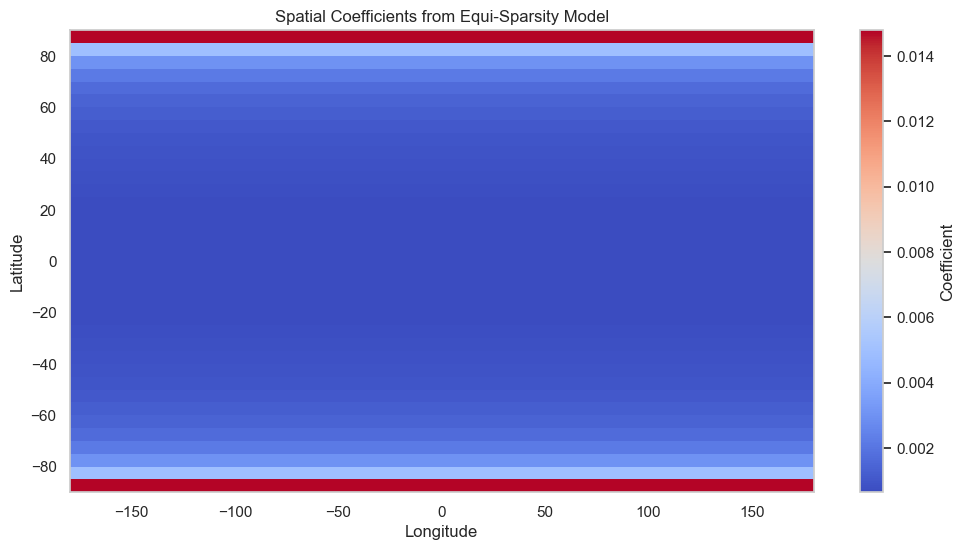

Visualization completed successfully.

Emergent Constraints with Spatial Dependence and Equi-Sparsity completed successfully.


In [32]:
# Section 5: Reshaping and Visualizing the Spatial Coefficients

print("\nReshaping and visualizing the spatial coefficients...")

# Ensure that beta_hat is not None
if beta_hat is not None:
    try:
        beta_map = beta_hat.reshape(M, L)  # shape: (lat, lon)
        print(beta_map)
        plt.figure(figsize=(12,6))
        plt.title("Spatial Coefficients from Equi-Sparsity Model")
        plt.pcolormesh(lons, lats, beta_map, cmap='coolwarm', shading='auto')
        plt.colorbar(label='Coefficient')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
        print("Visualization completed successfully.")
    except Exception as e:
        print(f"Error reshaping or visualizing beta_hat: {e}")
else:
    print("beta_hat is None. Cannot reshape or visualize coefficients.")

# Step 5: Progress Evaluation Print Statement
print("\nEmergent Constraints with Spatial Dependence and Equi-Sparsity completed successfully.")

In [ ]:
import cvxpy as cp
from sklearn.model_selection import KFold

# Assuming you have already defined the following variables:
# X: shape (N, p)
# Z: shape (N,)
# area_flat: shape (p,)
# dist_matrix: shape (p, p) - distances between grid boxes
# lons: array of longitude values
# lats: array of latitude values
# L: number of longitude grid points
# M: number of latitude grid points

# Define parameters for cross-validation
K = 5  # Number of cross-validation folds
lambda_values = np.logspace(-2, 1, 5)  # Reduced range of lambda values: [0.01, 0.1, 1, 10]
epsilon = 1e-3  # Small constant to avoid division by zero

p = X.shape[1]  # Number of grid boxes (e.g., 72 * 36 = 2592)
N = X.shape[0]  # Number of samples (e.g., 248)

# Step 1: Compute weights based on distance matrix
print("Computing weights based on distance matrix...")
W = np.zeros((p, p))
total_pairs = p * (p - 1) // 2
current_pair = 0
print_interval = 100000  # Print progress every 100,000 pairs

for j in range(p):
    for k in range(j + 1, p):
        W[j, k] = 1.0 / (dist_matrix[j, k] + epsilon)
        W[k, j] = W[j, k]
        
        current_pair += 1
        # if current_pair % print_interval == 0:
        #     print(f"  Processed {current_pair}/{total_pairs} grid box pairs...")

print("Weights computation completed.")

# Extract area weights s_j for each grid box
s = area_flat

# Initialize cross-validation results dictionary
cv_mse = {lambda_val: [] for lambda_val in lambda_values}

# Set up K-Fold cross-validation
kf = KFold(n_splits=K, shuffle=True, random_state=42)

print("\nStarting cross-validation to select the best lambda...")

for lambda_val in lambda_values:
    print(f"\nEvaluating lambda = {lambda_val}")
    fold = 1
    for train_index, val_index in kf.split(X):
        print(f"  Processing fold {fold}/{K} for lambda {lambda_val}")
        X_train, X_val = X[train_index], X[val_index]
        Z_train, Z_val = Z[train_index], Z[val_index]
        
        # Define the optimization variable
        beta = cp.Variable(p)
        
        # Define the loss term (1/(2N)) * ||Z_train - X_train * beta||²
        residual = Z_train - X_train @ beta
        loss = 0.5 * (1.0 / len(Z_train)) * cp.sum_squares(residual)
        
        # Define the equi-sparsity penalty
        penalty_terms = []
        total_inner_loops = p * (p - 1) // 2
        inner_current = 0
        inner_print_interval = 100000  # Print progress every 100,000 pairs

        for j in range(p):
            for k in range(j + 1, p):
                diff = (beta[j] * s[j] - beta[k] * s[k])
                penalty_terms.append(W[j, k] * cp.abs(diff))
                
                inner_current += 1
                if inner_current % inner_print_interval == 0:
                    print(f"    Processed {inner_current}/{total_inner_loops} grid box pairs in penalty computation...")
        
        penalty = cp.sum(penalty_terms)
        
        # Define the objective
        objective = loss + lambda_val * penalty
        problem = cp.Problem(cp.Minimize(objective))
        
        # Solve the problem
        try:
            problem.solve(solver=cp.OSQP, verbose=False)
            if problem.status in ["optimal", "optimal_inaccurate"]:
                beta_hat = beta.value
                # Predict on validation set
                Z_val_pred = X_val @ beta_hat
                mse = np.mean((Z_val - Z_val_pred) ** 2)
                cv_mse[lambda_val].append(mse)
                print(f"    Fold {fold}: MSE = {mse}")
            else:
                print(f"    Warning: Solver status {problem.status} for lambda {lambda_val} on fold {fold}")
                cv_mse[lambda_val].append(np.inf)
        except Exception as e:
            print(f"    Error solving for lambda {lambda_val} on fold {fold}: {e}")
            cv_mse[lambda_val].append(np.inf)
        
        fold += 1

# Step 2: Select the best lambda with the lowest average MSE
avg_cv_mse = {lambda_val: np.mean(mse_list) for lambda_val, mse_list in cv_mse.items()}
best_lambda = min(avg_cv_mse, key=lambda x: avg_cv_mse[x])
print(f"\nBest lambda selected from cross-validation: {best_lambda}")
print(f"Corresponding average CV MSE: {avg_cv_mse[best_lambda]}")

# Optional: Plot CV MSE vs Lambda
plt.figure(figsize=(8,6))
plt.semilogx(lambda_values, [avg_cv_mse[l] for l in lambda_values], marker='o')
plt.axvline(best_lambda, color='red', linestyle='--', label=f'Best lambda = {best_lambda}')
plt.title("Cross-Validation MSE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Average CV MSE")
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Fit the final model using the best lambda on the full dataset
print("\nFitting the final model with the best lambda on the full dataset...")

# Define the optimization variable
beta_final = cp.Variable(p)

# Define the loss term (1/(2N)) * ||Z - X * beta||²
residual_final = Z - X @ beta_final
loss_final = 0.5 * (1.0 / N) * cp.sum_squares(residual_final)

# Define the equi-sparsity penalty
penalty_terms_final = []
total_inner_loops_final = p * (p - 1) // 2
inner_current_final = 0
inner_print_interval_final = 100000  # Print progress every 100,000 pairs

for j in range(p):
    for k in range(j + 1, p):
        diff = (beta_final[j] * s[j] - beta_final[k] * s[k])
        penalty_terms_final.append(W[j, k] * cp.abs(diff))
        
        inner_current_final += 1
        if inner_current_final % inner_print_interval_final == 0:
            print(f"  Processed {inner_current_final}/{total_inner_loops_final} grid box pairs in final penalty computation...")

penalty_final = cp.sum(penalty_terms_final)

# Define the objective
objective_final = loss_final + best_lambda * penalty_final
problem_final = cp.Problem(cp.Minimize(objective_final))

# Solve the problem
print(f"Solving the equi-sparsity optimization problem with lambda = {best_lambda}...")
problem_final.solve(verbose=True, solver=cp.OSQP)

if problem_final.status in ["optimal", "optimal_inaccurate"]:
    beta_hat = beta_final.value
    print("Equi-sparsity coefficients solved successfully.")
else:
    print("Solver did not find an optimal solution. Status:", problem_final.status)

# Step 4: Reshape and Visualize the Spatial Coefficients
print("\nReshaping and visualizing the spatial coefficients...")

# Ensure that beta_hat is not None
if beta_hat is not None:
    try:
        beta_map = beta_hat.reshape(L, M)
        plt.figure(figsize=(12,6))
        plt.title("Spatial Coefficients from Equi-Sparsity Model")
        plt.pcolormesh(lons, lats, beta_map.T, cmap='coolwarm', shading='auto')
        plt.colorbar(label='Coefficient')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
        print("Visualization completed successfully.")
    except Exception as e:
        print(f"Error reshaping or visualizing beta_hat: {e}")
else:
    print("beta_hat is None. Cannot reshape or visualize coefficients.")

# Step 5: Progress Evaluation Print Statement
print("\nEmergent Constraints with Spatial Dependence and Equi-Sparsity completed successfully.")

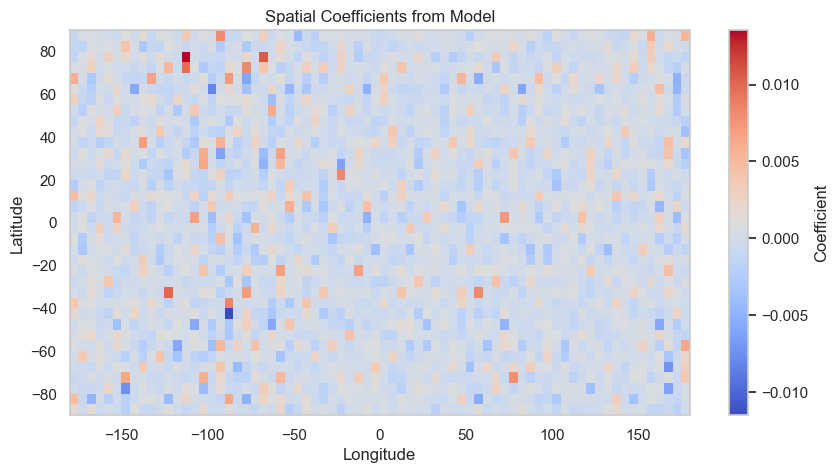

In [31]:
beta_map = beta_hat.reshape(L, M)
plt.figure(figsize=(10,5))
plt.title("Spatial Coefficients from Model")
plt.pcolormesh(lons, lats, beta_map.T, cmap='coolwarm')
plt.colorbar(label='Coefficient')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

These coefficients represent how each grid box’s historical trend contributes to predicting future warming. With an equi-sparsity penalty, we would see regions merging into uniform coefficient areas.


In [ ]:
# Estimate marginal distributions non-parametrically.
# For simplicity, just sort data and compute empirical CDFs.
def empirical_cdf(data):
    sorted_data = np.sort(data)
    ranks = np.argsort(np.argsort(data))
    return (ranks + 1) / (len(data) + 1)

U_X = np.apply_along_axis(empirical_cdf, 0, X) # U_X: N x p of uniform(0,1)
U_Z = empirical_cdf(Z)
# For Y, we have only one realization of observations (?), so we might just treat it differently.
# If we had multiple observational ensembles, we could do similarly.

In [ ]:
# Fit a Gaussian copula as an example
# If using the 'copulas' library:
# model = GaussianMultivariate()
# data_for_copula = pd.DataFrame(np.column_stack([U_X.mean(axis=1), U_Z]), columns=['X_global','Z'])
# model.fit(data_for_copula)

# Without an actual copula library here, just placeholder
# TODO: Implement or use an available copula fitting method.

In [ ]:
# Derive conditional distributions Z|Y using the copula model.
# TODO: With a fitted copula model, you would:
# 1. Convert Y to U_Y via empirical CDF.
# 2. Condition on U_Y and U_X to derive the conditional distribution of Z.
# This step is non-trivial and depends on copula properties.

# Placeholder code:
# U_Y = empirical_cdf(Y) # If Y is a single realization, can't really do a standard CDF.

**Discussion:** With a fitted copula, we could incorporate non-Gaussian distributions. Here we only showed the setup. Actual implementation would require a proper copula fitting and conditioning method.

In [ ]:
# Compare predicted future trends from different methods (simple linear, ridge, etc.)
Z_pred_linear = lr.predict(X_global_mean.reshape(-1,1))
Z_pred_ridge = ridge_cv.predict(X)

# Simple comparison: plot predicted vs. actual Z for the ESM ensemble
plt.figure()
plt.scatter(Z, Z_pred_linear, alpha=0.7, label='Global Mean Model')
plt.scatter(Z, Z_pred_ridge, alpha=0.7, label='Spatial Ridge Model')
plt.plot([Z.min(), Z.max()], [Z.min(), Z.max()], 'k--')
plt.xlabel("Actual Z (ESM)")
plt.ylabel("Predicted Z")
plt.legend()
plt.title("Prediction Comparison")
plt.show()

The spatial model (even with simple ridge) might yield a better fit than the global mean model. Introducing the equi-sparsity penalty and then copula-based approaches would further refine this.

**Conclusion:**

- We started with a basic emergent constraint model using the global mean historical trend.
- We expanded to a spatially explicit model, discussed the use of equi-sparsity to handle high-dimensional regressions and improve interpretability.
- We introduced the concept of copula-based modeling to relax Gaussian assumptions.

Next steps:
- Implement the equi-sparsity penalty solver.
- Implement full copula-based inference and conditioning.
- Apply cross-validation and model selection rigorously.